# Lour's Pork Barrel Classifier (羅老師肉桶文本分類器)🐖
## Convolutional Neural Networks for Pork Barrel Project Classification 

-------------------------

### Stage 1: Libaries & Dependencies

In [1]:
# built-in library
import math
import re
import collections
import zipfile
import random
from itertools import chain

# ML & Deep Learning/ NLP toolkit
import pandas as pd
import numpy as np
import jieba
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

-------------------------

### Stage 2: Data Preprocessing (Training Data: Introduction of Bills and Legislation from 6th Session to 7th Session, 2004-2012)

#### (1) Read file 

In [2]:
# read file
df = pd.read_csv('data/Pork Bill - 2021-05-20.csv',encoding='utf-8')

# combine abstract of bill and title 
df['text'] =  df['Title'] + df['Content'].fillna(df['Title'])

# drop conten without having any characters
# view na's row: df[df['text'].isnull()==True]
data = df[['text', 'pork_bill']].dropna(subset=['text'])

In [3]:
print(" Pork Legislation", data['pork_bill'].value_counts()[1],'\n', 
      "None-Pork Legislation", data['pork_bill'].value_counts()[0])

 Pork Legislation 2510 
 None-Pork Legislation 4733


#### (2) Balancing the Training Samples

#### (2) Tokenization

In [4]:
import collections
import numpy as np
import jieba
from itertools import chain


def jieba_cut(filename):
    """
    cut Chinese and remove stop words
    Reference: https://www.cnblogs.com/Luv-GEM/p/10836454.html
    Stopwords: https://www.kaggle.com/rikdifos/english-and-chinese-stopwords?select=cn_stopwords.txt
    """
    stop_list = [i.strip() for i in open('cn_stopwords.txt','r',encoding='utf-8')]  
    news_cut = []
    news_list = []
    for line in filename:    
        if line:
            news_cut = list(jieba.cut(''.join(line),cut_all=False,HMM=True))  
            news_list.append([word.strip() for word in news_cut if word not in stop_list and len(word.strip())>0]) 
    news_list = list(chain.from_iterable(news_list))  
    return news_list

def clearPucts(context):
    """
    remove punctuation
    ref: https://chenyuzuoo.github.io/posts/28001/
    """
    context = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "", context)
    context = re.sub("[【】╮╯▽╰╭★→「」]+","", context)
    context = re.sub("！，❤。～《》：（）【】「」？”“；：、","",context)
    context = re.sub("\s","",context)
    return context

def seg_char(sent):
    """
    cut Chinese and remove stop words
    ref: https://blog.csdn.net/renyuanfang/article/details/86487367
    """
    # split
    pattern_char_1 = re.compile(r'([\W])')
    parts = pattern_char_1.split(sent)
    parts = [p for p in parts if len(p.strip())>0]
    # cut sentence
    pattern = re.compile(r'([\u4e00-\u9fa5])')
    chars = pattern.split(sent)
    chars = [w for w in chars if len(w.strip())>0]
    chars = ' '.join(chars)
    return chars

# import spacy
# # python3 -m spacy download zh_core_web_sm
# spacy_nlp = spacy.load("zh_core_web_sm")

# data_clean = [clearPucts(text) for text in data.text]
# data_clean = [[spacy_nlp(sentence).vector for sentence in data] for data in data_clean]

In [5]:
data_clean = [seg_char(text) for text in [clearPucts(text) for text in data.text]]

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**18)

data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

#### (3) Padding

In [6]:
MAX_LEN = max([len(sentence) for sentence in data_clean])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)


#### (4) Spliting Training/ Testing Set

In [7]:
data_labels = data.pork_bill.values

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    data_inputs, data_labels, test_size=0.33, random_state=42)

print("Shape of X Train:", train_inputs.shape, '\n'
      "Shape of X Test :", test_inputs.shape,'\n'
      "Shape of Y Trian:", train_labels.shape , '\n'
      "Shape of Y Test :", test_labels.shape )

Shape of X Train: (4852, 785) 
Shape of X Test : (2391, 785) 
Shape of Y Trian: (4852,) 
Shape of Y Test : (2391,)


In [9]:
unique_train_labels, counts_train_labels = np.unique(train_labels, return_counts=True)

print(' Num of Train Set:' , train_inputs.shape[0], '\n'
      ,'Not Pork vs Pork:', dict(zip(unique_train_labels, counts_train_labels)))

 Num of Train Set: 4852 
 Not Pork vs Pork: {0: 3167, 1: 1685}


In [10]:
unique_test_labels, counts_test_labels = np.unique(test_labels, return_counts=True)

print(' Num of Test Set:' , test_inputs.shape[0], '\n'
      ,'Not Pork vs Pork:', dict(zip(unique_test_labels, counts_test_labels)))

 Num of Test Set: 2391 
 Not Pork vs Pork: {0: 1566, 1: 825}


-------------------------


### Stage 3: Model and Building

#### (1) Using the Subclassing API to Build Dynamic Model

In [11]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=100,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size, 
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters, 
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D() # no training variable so we can
                                             # use the same layer for each
                                             # pooling step
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.last_dense = layers.Dense(units=1, activation="sigmoid")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)        
        return output


In [12]:
VOCAB_SIZE = tokenizer.vocab_size  # 5000 tokenizer.vocab_size
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2 #len(set(train_labels))
DROPOUT_RATE = 0.2
BATCH_SIZE = 150
NB_EPOCHS = 80

Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

#### (2) Compile and Summary of the Model

In [13]:
Dcnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
Dcnn.build(input_shape = (train_inputs.shape[1] , EMB_DIM)) # (train_inputs.shape[1] , EMB_DIM)  (785 , EMB_DIM)
Dcnn.summary()

Model: "dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  586600    
_________________________________________________________________
conv1d (Conv1D)              multiple                  40100     
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  80100     
_________________________________________________________________
global_max_pooling1d (Global multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  77056     
_________________________________________________________________
dropout (Dropout)            multiple                  0      

#### (3) Check Point Path

In [14]:
checkpoint_path = "checkpoint_recode/ckpt_manager"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Checkpoint Located!!")

-------------------------

### Stage 4: Train the Model

In [15]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [16]:
Dcnn.fit(train_inputs,
         train_labels,
         validation_data=(test_inputs, test_labels),
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS,
         callbacks=[early_stop]
        )
ckpt_manager.save()

Epoch 1/80
33/33 [==============================] - 25s 746ms/step - loss: 0.5666 - accuracy: 0.6956 - val_loss: 0.3949 - val_accuracy: 0.8335
Epoch 2/80
33/33 [==============================] - 25s 771ms/step - loss: 0.2621 - accuracy: 0.8980 - val_loss: 0.1949 - val_accuracy: 0.9322
Epoch 3/80
33/33 [==============================] - 26s 796ms/step - loss: 0.1175 - accuracy: 0.9586 - val_loss: 0.1524 - val_accuracy: 0.9498
Epoch 4/80
33/33 [==============================] - 27s 834ms/step - loss: 0.0662 - accuracy: 0.9794 - val_loss: 0.1641 - val_accuracy: 0.9469
Epoch 5/80
33/33 [==============================] - 31s 929ms/step - loss: 0.0532 - accuracy: 0.9847 - val_loss: 0.1694 - val_accuracy: 0.9469
Epoch 6/80
33/33 [==============================] - 27s 813ms/step - loss: 0.0508 - accuracy: 0.9835 - val_loss: 0.1769 - val_accuracy: 0.9477
Epoch 7/80
33/33 [==============================] - 26s 795ms/step - loss: 0.0485 - accuracy: 0.9843 - val_loss: 0.1674 - val_accuracy: 0.9460

'checkpoint_recode/ckpt_manager/ckpt-1'

-------------------------

### Stage 5: Evaluation

In [17]:
losses = pd.DataFrame(Dcnn.history.history)
losses

,loss,accuracy,val_loss,val_accuracy
0,0.566634,0.695589,0.394911,0.833542
1,0.262108,0.897980,0.194929,0.932246
2,0.117519,0.958574,0.152416,0.949812
3,0.066210,0.979390,0.164076,0.946884
4,0.053167,0.984749,0.169427,0.946884
5,0.050823,0.983512,0.176871,0.947721
6,0.048465,0.984336,0.167404,0.946048
7,0.046040,0.985573,0.168995,0.947302


##### a bit overfitting due to less validation set ⚠️⚠️⚠️⚠️

<AxesSubplot:>

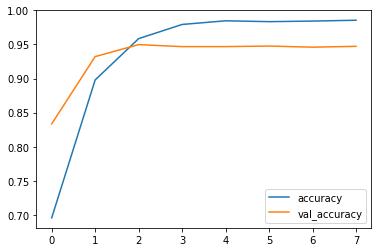

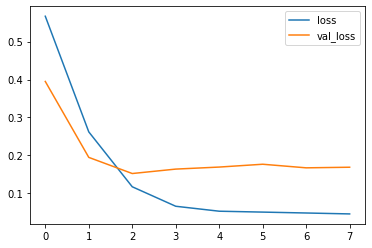

In [18]:
losses[['accuracy','val_accuracy']].plot()
losses[['loss','val_loss']].plot()

In [19]:
from sklearn.metrics import classification_report,confusion_matrix

In [20]:
evaluation_model = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(evaluation_model)

16/16 [==============================] - 2s 147ms/step - loss: 0.1690 - accuracy: 0.9473
[0.16899529099464417, 0.9473024010658264]


In [21]:
# pd.DataFrame(confusion_matrix(test_labels,predictions))
predictions = Dcnn.predict(test_inputs)
predictions = np.where(predictions >0.8 , 1, 0)
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1566
           1       0.94      0.90      0.92       825

    accuracy                           0.95      2391
   macro avg       0.95      0.94      0.94      2391
weighted avg       0.95      0.95      0.95      2391



In [22]:
t = pd.DataFrame(confusion_matrix(test_labels,predictions), 
             columns=['Predictions: Not Pork(0)','Predictions:Pork(1)'])
t.index = ['Acutal: Not Pork(0)', 'Acutal: Pork (1)']
t

,Predictions: Not Pork(0),Predictions:Pork(1)
Acutal: Not Pork(0),1521,45
Acutal: Pork (1),81,744


-------------------------

### Stage 6: Try the Model with New Data and Export an End-to-end Model


#### (1) Test New Dataset from 2000 samples from Legislative Questions from 6th Session 

In [23]:
def as_num(x):
    """
    keep 10 decimals
    """
    y = '{:.15f}'.format(x) 
    return y

In [24]:
import pandas as pd
import random

# test the trined model using new text from 200 samples from Leislative Questions
LQ6 = pd.read_csv('data/LQ_6th.csv')

# drop '0': legislor  never have proposed any legisaltive questions. 
LQ6 = LQ6[LQ6['title'].isin(['0'])== False]

# select text with number of charecters within EMB_DIM; len(sub_set) = 11162
# sample_df = LQ6.loc[[len(char_num) for char_num in LQ6.title if len(char_num) < MAX_LEN], ['legislator','title', 'topic', 'category', 'keywords', 'ques_type']].reset_index(drop=True)
random.seed(42)
sample_df = LQ6.iloc[random.sample(range(len(LQ6)), 2000)][['legislator', 'title', 'topic', 'category', 'keywords', 'ques_type']]
sub_set = [seg_char(text) for text in [clearPucts(text) for text in sample_df.title]]


##### Top 10 of 2000 Samples

In [30]:
pd.DataFrame(
    {'legislator': sample_df.legislator,
     'Pork Value(Constituency Interest)':[as_num(Dcnn(np.array([tokenizer.encode(line)]), training=True).numpy()[0][0]) for line in sub_set],
     'Legislative Questions ': sample_df.title,
     'Topic': sample_df.topic,
     'Key Word':sample_df.keywords}).sort_values(by=['Pork Value(Constituency Interest)'], ascending = False).head(15)

,legislator,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
9892,陳啟昱,0.996169388294220,鑑於現行《所得稅法》第十七條規定特別扣除額教育支出部分，僅以納稅義務人之子女就讀大專院校為限...,所得稅 ; 教育費用 ; 扣除額,所得稅法 ; 特別扣除額 ; 教育支出
8343,蔡煌瑯(離職),0.993016242980957,「2005南投花卉嘉年華」活動爭取中央經費補助案由，特向行政院提出質詢。,農業推廣 ; 政府補助,南投花卉嘉年華 ; 中央經費
1761,彭添富,0.991446614265442,針對「辦理九十四年原住民中低收入戶家庭租屋補助計畫」專案補助計畫，特向行政院提出質詢。,原住民族生活,原住民中低收入戶 ; 租屋補助
8347,蔡煌瑯(離職),0.991061806678772,「2005南投花卉嘉年華」活動爭取中央經費補助案由，特向行政院提出質詢。,農業推廣 ; 政府補助,南投花卉嘉年華 ; 中央經費
3999,林正峰,0.989558458328247,針對政府準備修法推動「二代健保」，健保保費採取「年度所得總額」為計算基礎，而非採用扣除免稅額...,國民 ; 健康保險 ; 保險費,二代健保 ; 年度所得總額
8344,蔡煌瑯(離職),0.987711191177368,「2005南投花卉嘉年華」活動爭取中央經費補助案由，特向行政院提出質詢。,農業推廣 ; 政府補助,南投花卉嘉年華 ; 中央經費
35,丁守中,0.987428069114685,針就民眾陳情指出，目前政府對身心障礙者提供之生活津貼，依身心障礙程度等級分為1000元至50...,身心障礙者福利,身心障礙者生活津貼
8345,蔡煌瑯(離職),0.985303997993469,「2005南投花卉嘉年華」活動爭取中央經費補助案由，特向行政院提出質詢。,農業推廣 ; 政府補助,南投花卉嘉年華 ; 中央經費
7382,盧秀燕,0.983980000019073,針對早期退除役軍官給與補助金發放金額過低，實無法解決終身生活所需，希望相關單位考量實際情況，...,榮民福利,早期退除役軍官給與補助金
8340,蔡煌瑯(離職),0.979868054389954,「2005南投花卉嘉年華」活動爭取中央經費補助案由，特向行政院提出質詢。,農業推廣 ; 政府補助,南投花卉嘉年華 ; 中央經費


##### Last 10 Rows of 2000 Samples

In [26]:
pd.DataFrame(
    {'legislator': sample_df.legislator,
     'Pork Value(Constituency Interest)':[as_num(Dcnn(np.array([tokenizer.encode(line)]), training=True).numpy()[0][0]) for line in sub_set],
     'Legislative Questions ': sample_df.title,
     'Topic': sample_df.topic,
     'Key Word':sample_df.keywords}).sort_values(by=['Pork Value(Constituency Interest)'], ascending = False).tail(15)

,legislator,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
2534,李復甸,0.000021549063604,鑑於刑事偵察實務上緩起訴制度，有淪於檢察官為同案被告間不利證詞取得之交換手段之虞，破壞緩起訴...,偵查 ; 訴訟程序,刑事偵察 ; 秘密證人
3361,林建榮,0.000020212990421,為立法院朝野協商修改銀行法，明定信用卡、現金卡循環利率與銀行公布的基本放款利率差距不得超過十...,金融管理 ; 銀行管理,銀行法 ; 現金卡 ; 循環利率 ; 卡債
3712,林正峰,0.000019731034627,針對行政院長張俊雄日前穿著輕便的長袖白襯衫，要求各級機關和學校身體力行節約能源，當場台下官員...,能源政策,節約能源
4124,林正峰,0.000019187420548,鑑於近年來臺灣地區毒品氾濫，吸毒人數劇增，危害國民身心健康甚鉅，因而滋生之犯罪更成為影響社會...,煙毒勒戒 ; 醫院,吸毒 ; 署立醫院 ; 毒品戒治專責機構
6091,王幸男,0.000017634354663,針對道路人孔蓋或管線挖掘後回填品質不佳，或是公共安全沒有做好，導致各種傷害和死亡案件，一直居...,公共安全,人孔蓋 ; 公共安全 ; 道路品質
7429,管碧玲,0.000013002485503,針對近日台灣鐵路管理局發生網路訂票系統遭到內部人員惡意壟斷，導致一般民眾訂票權益受損之弊端；...,鐵路管理 ; 車票,網路訂票 ; 壟斷 ; 台鐵
10798,黃敏惠(離職),0.000011985112906,就近日來爆發知名提神飲料遭下毒事件，已知有四位台中市民因誤喝中毒，並有一人已不治死亡。此一類...,飲料 ; 中毒,飲料 ; 下毒 ; 千面人
10120,陳朝龍,0.000011277100384,針對英國政府宣稱台灣出口至該國禽鳥，檢驗出感染禽流感H5N1病毒死亡。由於我國迄今並未發現有...,傳染病防治 ; 走私,英國政府 ; 台灣禽鳥 ; 禽流感 ; 相思鳥 ; 走私
4356,林進興,0.000007685628589,針對行政院金融監督管理委員會為了解決國人廣大的卡債問題，積極推廣債務協商機制，政策本意良好，...,信用卡 ; 債務,卡債 ; 協商機制
8839,賴清德,0.000006586606105,針對市售豆類製品疑含「過氧化氫」情形嚴重，傷害消費者健康，爰要求相關單位依食品衛生管理法切實...,食品管理,豆類製品 ; 過氧化氫


#### (2) Export an End-to-end Model


In [27]:
from tensorflow.keras.models import load_model

In [28]:
# Get model (Sequential, Functional Model, or Model subclass)
Dcnn.save('lour_pork_model')

INFO:tensorflow:Assets written to: lour_pork_model/assets


INFO:tensorflow:Assets written to: lour_pork_model/assets


In [29]:
from tensorflow import keras
model = keras.models.load_model('lour_pork_model')